Author : Hind Bakkali - M1-IRIFS
# Coding project - Tumour segmentation
## Project statement
The goal of this project is to create an algorithm to automatically segment the tumour in the brain MRI image.

Given that the resolution of the image is of 0.115 cm/px in both axis, estimate the area of the tumour (in cm²).


## Project implementation

Segmentation can be done in several ways. We should choose a method
that takes advantage of the image type (here a medical image, where the tumour is
clearly brighter than the rest). Two methods will be explored here : histogram-based and region-based segmentation.

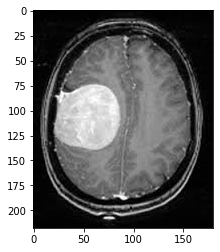

In [8]:
# import all libraries/packages needed
import numpy as np
from skimage.io import imread
from matplotlib import pyplot as plt
from skimage.filters import median
from skimage.morphology import disk, erosion, dilation
from skimage.color import rgb2gray
import skimage.filters.rank as skr
from skimage.segmentation import mark_boundaries, watershed

# define histograms functions
def norm_hist(im):
    hist,bins = np.histogram(im.flatten(),range(256))  # histogram is computed on a 1D distribution --> flatten()
    return 1.*hist/np.sum(hist) # normalized histogram
def cumul_hist(im):
    nh = norm_hist(im)
    return np.append(np.array(0),np.cumsum(nh))

# load image
brain = (rgb2gray(imread('mri_brain.jpg'))*255).astype("uint8")
plt.gray()
plt.imshow(brain)


**Pre-processing**

First, we pre-process the image to have a good starting point for the segmentation.
The goal here is to make the tumour clearly discernable from the rest of the image.

<Figure size 432x288 with 0 Axes>

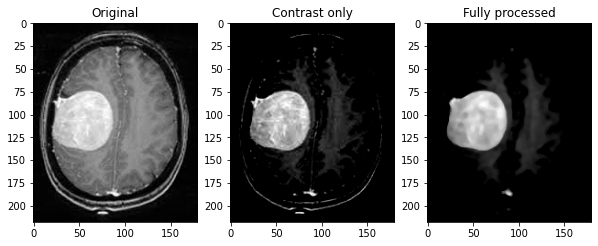

In [2]:
#enhance contrast (choose thresholds such that tumour is clearly enhanced)
def contrast(im, min, max):
    lut = np.arange(256)
    lut[0:min] = 0
    lut[max:255] = 255
    lut[min:max] = np.floor(np.linspace(0,255,max-min)) #linear interpolation /b/ min and max
    return lut[im]

def median_filter(im, radius):
    res = im.copy()
    # 1 color channel
    if len(im.shape) == 2:
        res = median(res, disk(radius))
    # 3 color channels
    elif len(im.shape) == 3:
        res[:,:,0] = median(res[:,:,0], disk(radius))
        res[:,:,1] = median(res[:,:,1], disk(radius))
        res[:,:,2] = median(res[:,:,2], disk(radius))
    return res.astype("uint8")

processed = median_filter(contrast(brain,120,255),3)

plt.gray()
plt.figure(figsize=[10,5])
plt.subplot(1,3,1)
plt.imshow(brain)
plt.title("Original")
plt.subplot(1,3,2)
plt.imshow(contrast(brain,120,255))
plt.title("Contrast only")
plt.subplot(1,3,3)
plt.imshow(processed)
plt.title("Fully processed")
plt.show()

As we can see in the images above, the 1st function (contrast), allows us to accentuate
the intensity difference between the tumour pixels and the rest of the image. Then,
a median filter is used to smooth it and make the tumour stand out even more.

The reason why the median filter was chosen (and not gaussian, mean or else), is that
it preserves the edges, they are not blurred.

NB : one might think that the pre-processing reduced the size of the image, but it is actually
an optical illusion, the darker surroundings make it look smaller, but
reporting a few points of the edges on the axes confirmed that the position of the edges
did not change.

Now that the separation between the tumour and the background is even more visible,
we can start the segmentation.

**Histogram-based segmentation**

*First, we should analyze the histogram of the processed image :*

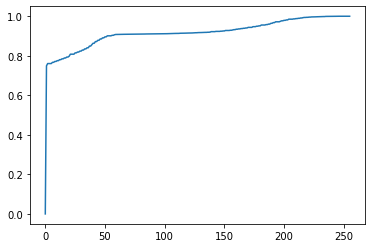

In [3]:
plt.plot(cumul_hist(processed))

We can see that the pre-processing helps a lot. Almost 80% of the image is
very dark, leaving around 20% of tumour and lighter tissues.
Let's use the **Otsu** threshold to try to separate these 20% :

c:\users\utilisateur\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


Otsu threshold =  93


<Figure size 432x288 with 0 Axes>

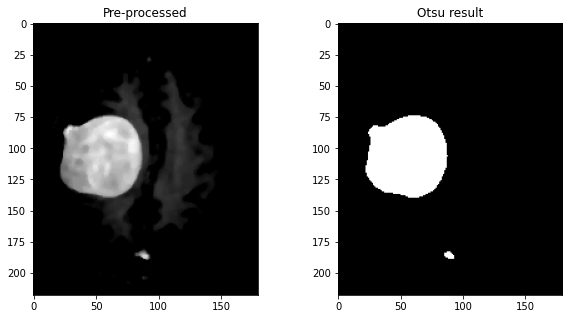

In [4]:
# Otsu algo with h = probability hist. = normalized hist.
def otsu_threshold(h):
    # Check every possible threshold
    best_l = 0
    best_t = 0

    var_within = np.zeros(len(h))
    var_between = np.zeros(len(h))
    sep = np.zeros(len(h))
    for t in range(1,len(h)-1):
        # Class probabilities
        w0 = h[:t].sum()
        w1 = h[t:].sum()
        # Class means
        m0 = (np.arange(0,t)*h[:t]).sum()/w0
        m1 = (np.arange(t,len(h))*h[t:]).sum()/w1
        # Class variances
        s0 = (((np.arange(0,t)-m0)**2)*h[:t]).sum()/w0
        s1 = (((np.arange(t,len(h))-m1)**2)*h[t:]).sum()/w1
        # Intra-class
        sw = w0*s0+w1*s1
        # Inter-class
        sb = w0*w1*((m1-m0)**2)
        # Separability
        l = sb/sw
        if( l > best_l ):
            best_l = l
            best_t = t
        var_within[t] = sw
        var_between[t] = sb
        sep[t] = l

    return best_t, var_within, var_between, sep

Otsu_T = otsu_threshold(norm_hist(processed))[0]
Otsu_segm = processed > Otsu_T
print("Otsu threshold = ", Otsu_T)

plt.gray()
plt.figure(figsize=[10,5])
plt.subplot(1,2,1)
plt.imshow(processed)
plt.title("Pre-processed")
plt.subplot(1,2,2)
plt.imshow(Otsu_segm)
plt.title("Otsu result")
plt.show()

The result obtained is pretty good, we just have to remove the little spot
that remains at the bottom of the image. To do so, we use opening with a structuring
element bigger than that spot :

<Figure size 432x288 with 0 Axes>

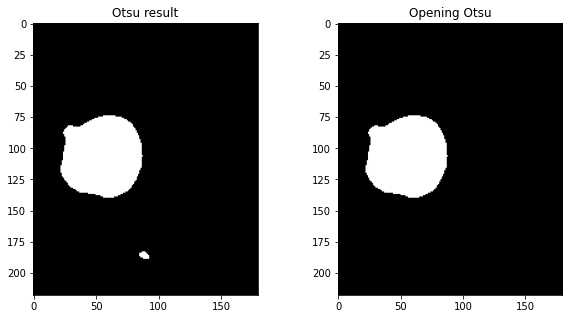

Number of tumour pixels detected :  3454
Estimated tumour area :  45.67915  cm²


In [5]:
hist_segm = dilation(erosion(Otsu_segm,disk(3)),disk(3)) > 0

plt.gray()
plt.figure(figsize=[10,5])
plt.subplot(1,2,1)
plt.imshow(Otsu_segm)
plt.title("Otsu result")
plt.subplot(1,2,2)
plt.imshow(hist_segm)
plt.title("Opening Otsu")
plt.show()

hist_pixels= (hist_segm == 1).sum()
print("Number of tumour pixels detected : ", hist_pixels)
hist_area = hist_pixels * 0.115**2
print("Estimated tumour area : ", hist_area," cm²")


**Region-based segmentation**

Let's now verify if we get a similar result with another segmentation method.
To this end, we use the watershed transform that is done in 3 steps :
* Compute the gradient image
* Select markers
* Apply watershed with those markers

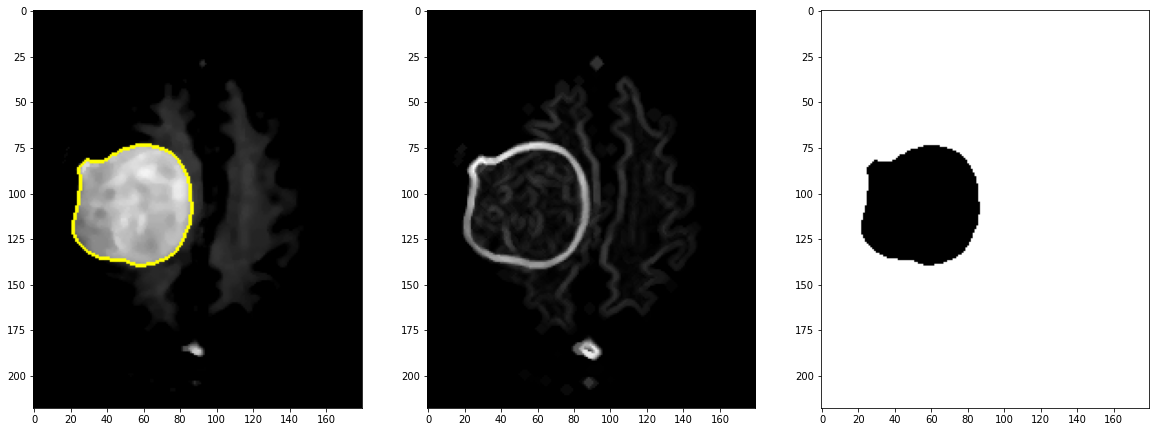

Number of tumour pixels detected :  3423
Estimated tumour area :  45.269175000000004  cm²


In [6]:
#1 Compute the gradient image
gradient = skr.gradient(processed, disk(2))

#2 Select markers
markers = np.zeros_like(processed)
markers[100,50] = 1 #Tumor
markers[200,10] = 2 #Darkest parts
#3 Apply watershed with those markers.
ws = watershed(gradient, markers)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(mark_boundaries(processed,ws))
plt.subplot(1,3,2)
plt.imshow(gradient,cmap=plt.cm.gray)
plt.subplot(1,3,3)
plt.imshow(ws)
plt.show()

region_segm = ws == 1

region_pixels= (region_segm == 1).sum()
print("Number of tumour pixels detected : ", region_pixels)
region_area = region_pixels * 0.115**2
print("Estimated tumour area : ", region_area," cm²")


**Final comparison**

<Figure size 432x288 with 0 Axes>

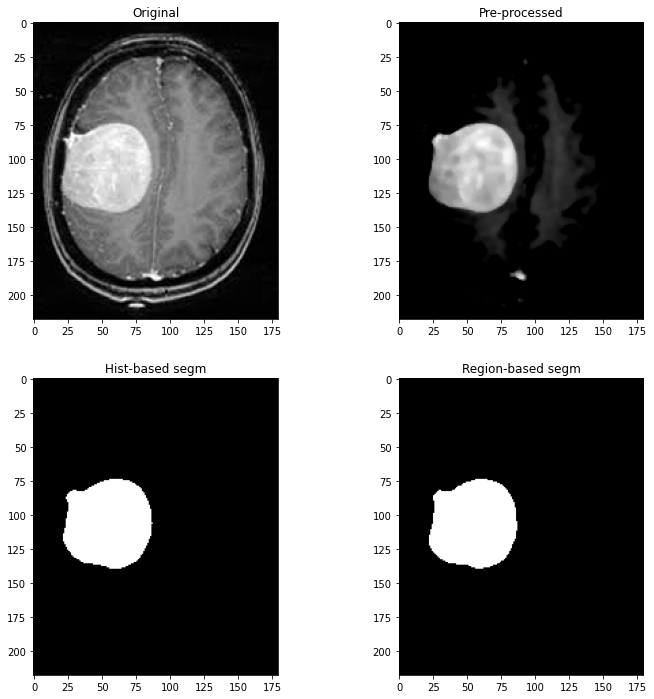

Histogram based (Otsu) :
Number of tumour pixels detected :  3454
Estimated tumour area :  45.67915  cm²

Region based (Watershed) :
Number of tumour pixels detected :  3423
Estimated tumour area :  45.269175000000004  cm²


In [11]:
plt.gray()
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
plt.imshow(brain)
plt.title("Original")
plt.subplot(2,2,2)
plt.imshow(processed)
plt.title("Pre-processed")
plt.subplot(2,2,3)
plt.imshow(hist_segm)
plt.title("Hist-based segm")
plt.subplot(2,2,4)
plt.imshow(region_segm)
plt.title("Region-based segm")
plt.show()


print("Histogram based (Otsu) :")
print("Number of tumour pixels detected : ", hist_pixels)
print("Estimated tumour area : ", hist_area," cm²")
print("")
print("Region based (Watershed) :")
print("Number of tumour pixels detected : ", region_pixels)
print("Estimated tumour area : ", region_area," cm²")

**Conclusion**

As we can see above, the segmentations give very similar results. What probably helped a lot
was the pre-processing. Enhancing the contrast and smoothing the image allowed
to start both segmentations with a very good basis, and end up with results that are only
30 pixels apart.